Computer Vision - Assignment 2 - Part 2.2 

# Uncalibrated Stereo

In [153]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

Steps to solve the uncalibrated stereo problem

1. Assume the camera matrix K is known for each camera
2. Find new reliable correspondence points (e.g., 8 points minimum using SIFT)
3. Find relative camera position t and orientation R
4. Find dense correspondence
5. Compute depth

Step 1: On assumption that camera matrix and focal length is known and the same camera model is used, we will reuse the camera matrix and focal length derived from the previous assignment. 

Step 2: Find correspondence points using SIFT

In [143]:
#Detect and match keypoints with SIFT and FLANN Matcher

MIN_MATCH_COUNT = 10

img1 = cv.imread(r'./imgs/img4.jpeg', cv.IMREAD_GRAYSCALE) 
img2 = cv.imread(r'./imgs/img5.jpeg', cv.IMREAD_GRAYSCALE)

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [144]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

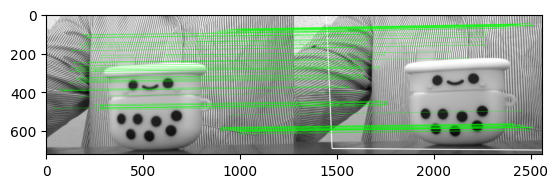

(<matplotlib.image.AxesImage at 0x14f395990>, None)

In [145]:
#Draw matched key points
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, 
                   flags = 2)
matches = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(matches, 'gray'),plt.show()

In [146]:
# Calculate the fundamental matrix for the cameras

pts1 = np.int32(src_pts)
pts2 = np.int32(dst_pts)
fundamental_matrix, inliers = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]

print("Calculated Fundamental Matrix: \n", fundamental_matrix)

Calculated Fundamental Matrix: 
 [[ 3.03427822e-07  3.54360839e-05 -2.88652292e-02]
 [-3.28741963e-05 -1.18531085e-05 -1.86317973e-01]
 [ 2.71842151e-02  1.86602080e-01  1.00000000e+00]]


In [147]:
tuple(pts1[1][0])

(10, 398)

In [154]:
## Draw epipolarlines

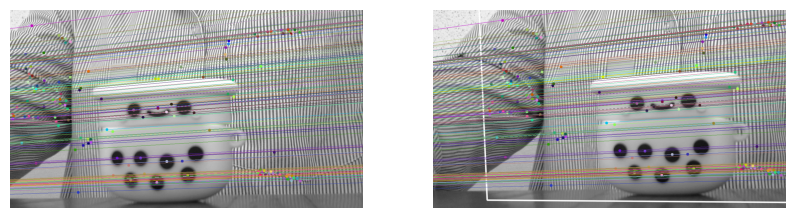

In [148]:
# Visualize epilines
# Adapted from: https://docs.opencv.org/master/da/de9/tutorial_py_epipolar_geometry.html
def drawlines(img1src, img2src, lines, pts1src, pts2src):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c = img1src.shape
    img1color = cv.cvtColor(img1src, cv.COLOR_GRAY2BGR)
    img2color = cv.cvtColor(img2src, cv.COLOR_GRAY2BGR)
    # Edit: use the same random seed so that two images are comparable!
    np.random.seed(0)
    for r, pt1, pt2 in zip(lines, pts1src, pts2src):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1color = cv.line(img1color, (x0, y0), (x1, y1), color, 1)
        img1color = cv.circle(img1color, tuple(pt1[0]), 5, color, -1)
        img2color = cv.circle(img2color, tuple(pt2[0]), 5, color, -1)
    return img1color, img2color

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(
    pts2, 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(
    pts1, 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

#Show epipolar lines in images
fig = plt.figure(figsize = (10,10))
plt.subplot(121), plt.axis("off"), plt.imshow(img5),
plt.subplot(122), plt.axis("off"), plt.imshow(img3)
plt.show()

## Rectify image

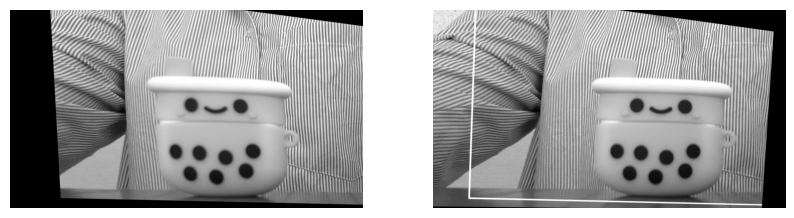

In [149]:
h1, w1 = img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

# Undistort (rectify) the images 
img1_rectified = cv.warpPerspective(img1, H1, (w1, h1))
img2_rectified = cv.warpPerspective(img2, H2, (w2, h2))

#Show rectified in images
fig = plt.figure(figsize = (10,10))
plt.subplot(121), plt.axis("off"), plt.imshow(img1_rectified, "gray"),
plt.subplot(122), plt.axis("off"), plt.imshow(img2_rectified, "gray")
plt.show()
# cv.imwrite("rectified_1.png", img1_rectified)
# cv.imwrite("rectified_2.png", img2_rectified)

True

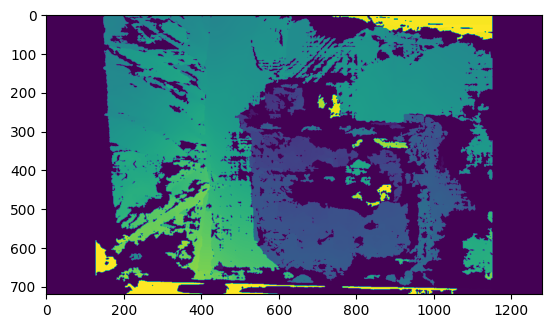

In [152]:
#Generate Depth Map

block_size = 9
min_disp = -128
max_disp = 128
num_disp = max_disp - min_disp
uniquenessRatio = 5
speckleWindowSize = 200
speckleRange = 2
disp12MaxDiff = 0

stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)
disparity_SGBM = stereo.compute(img1_rectified, img2_rectified)

# Normalize the values to a range from 0..255 for a grayscale image
disparity_SGBM = cv.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                              beta=0, norm_type=cv.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)


plt.imshow(disparity_SGBM)
cv.imwrite("depth_map_uncalibrated.png", disparity_SGBM)